In [2]:
import os
import random
import glob
import gc  # garbage collector

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import cv2

# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (Conv2D, Input, MaxPooling2D, 
                                     Dropout, concatenate, UpSampling2D, BatchNormalization, Conv2DTranspose)
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import backend as K

import warnings
warnings.filterwarnings('ignore')

2024-07-20 12:36:44.811494: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-20 12:36:44.811612: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-20 12:36:44.956950: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
else:
    print("No GPUs found. Please ensure CUDA and cuDNN are properly installed.")

No GPUs found. Please ensure CUDA and cuDNN are properly installed.


In [4]:
FULL_SHAPE = (768, 768)
NEW_SHAPE = (128, 128)

# Utility functions

In [5]:
def image_from_path(img_dir, img_name):
    
    img_path = os.path.join(img_dir, img_name)
    
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, NEW_SHAPE)
    image = image / 255.0  # Normalize to [0, 1]
    
    return np.expand_dims(image, axis=0)

# Load U-Net model

In [6]:
def create_conv2d_block(input_tensor, num_filters, kernel_size=3, batchnorm=True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    
    # 1st layer
    x = Conv2D(filters = num_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    
    if batchnorm:
        x = BatchNormalization()(x)
        
    x = keras.layers.Activation('relu')(x)
    
    # 2nd layer
    x = Conv2D(filters = num_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    
    if batchnorm:
        x = BatchNormalization()(x)
    
    x = keras.layers.Activation('relu')(x)
    
    return x

In [7]:
def create_unet(input_shape, num_filters=16, dropout=0.1, batchnorm=True):
    """
    Function to define the UNET Model
    input_shape: (height, width, 3)
    """
    
    assert input_shape[-1] == 3  # image must have 3 channels
    
    # input 'layer'
    #input_img = Input((*input_shape, 3), name='img')
    input_img = Input(input_shape, name='img')
    
    # downsampling (encoder)
    c1 = create_conv2d_block(input_img, num_filters * 1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = create_conv2d_block(p1, num_filters * 2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = create_conv2d_block(p2, num_filters * 4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = create_conv2d_block(p3, num_filters * 8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    # bottleneck
    c5 = create_conv2d_block(p4, num_filters * 16, kernel_size=3, batchnorm=batchnorm)
    
    # upsampling (decoder)
    u6 = Conv2DTranspose(num_filters * 8, (3, 3), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = create_conv2d_block(u6, num_filters * 8, kernel_size=3, batchnorm=batchnorm)
    
    u7 = Conv2DTranspose(num_filters * 4, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = create_conv2d_block(u7, num_filters * 4, kernel_size=3, batchnorm=batchnorm)
    
    u8 = Conv2DTranspose(num_filters * 2, (3, 3), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = create_conv2d_block(u8, num_filters * 2, kernel_size=3, batchnorm=batchnorm)
    
    u9 = Conv2DTranspose(num_filters * 1, (3, 3), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = create_conv2d_block(u9, num_filters * 1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    
    return model

In [8]:
input_shape = (*NEW_SHAPE, 3)
unet_weights_path = '/kaggle/input/ship_detection_unet/tensorflow2/v1/1/model-Unet.weights.h5'

unet_model = create_unet(input_shape)
unet_model.load_weights(unet_weights_path)

# Make predictions

In [9]:
test_images_folder_path = '/kaggle/input/airbus-ship-detection/test_v2'
test_images_filenames =  [os.path.basename(filename) for filename in glob.glob(test_images_folder_path + '/*')]

In [10]:
len(test_images_filenames), test_images_filenames[:10]

(15606,
 ['4291f3a66.jpg',
  'b0808caaf.jpg',
  '9f582d5ce.jpg',
  '916ae8dd3.jpg',
  '6fa533973.jpg',
  'e0cf877a8.jpg',
  '5e5085535.jpg',
  '51ffc3d65.jpg',
  '6dce1205c.jpg',
  'b0c08f452.jpg'])

In [11]:
some_image = image_from_path(test_images_folder_path, test_images_filenames[1])
some_image.shape

(1, 128, 128, 3)

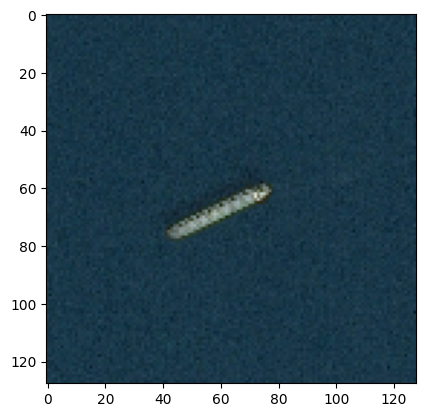

In [12]:
plt.imshow(some_image.squeeze(axis=0))
plt.show()

In [19]:
def make_prediction(model, image):
    threshold = 0.5
    
    # get probability for each pixel (-> np.ndarray)
    prob_mask = model.predict(some_image).squeeze(0)
    
    segmentation_mask = np.zeros(prob_mask.shape)
    # Convert probabilities to binary segmentation mask
    segmentation_mask = (prob_mask > threshold).astype(np.uint8)
    return segmentation_mask

In [14]:
some_image_mask = make_prediction(unet_model, some_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step


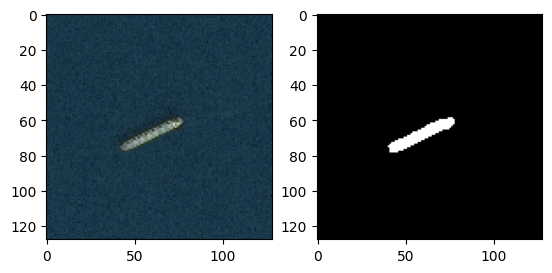

In [18]:
fig, ax = plt.subplots(ncols=2)

ax[0].imshow(some_image.squeeze(0))
ax[1].imshow(some_image_mask, cmap='gray')
plt.show()